In [176]:
mat_x(x) = [1.f0 0.f0] * x
mat_y(x) = [0.f0 1.f0] * x

function diff(
    y,
    x,
)

    dy = zeros(eltype(y), axes(y))

    idx = eachindex(y) |> collect
    i0 = idx[1]
    i1 = idx[end]

    dy[i0] = (y[i0+1] - y[i0]) / (x[i0+1] - x[i0] + 1e-7)
    dy[i1] = (y[i1] - y[i1-1]) / (x[i1] - x[i1-1] + 1e-7)
    for i = i0+1:i1-1
        dy[i] = (y[i+1] - y[i-1]) / (x[i+1] - x[i-1] + 1e-7)
    end

    return dy

end

diff (generic function with 1 method)

In [109]:
using Flux.Zygote

In [167]:
nx = 100
ω = 1.;

X = collect(range(0, 1, length=nx)) |> permutedims
Y = zeros(axes(X));

In [169]:
ann = FastChain(FastDense(1, 20, tanh), FastDense(20, 1))
p = initial_params(ann);
θ = [vcat(X...); p];

In [170]:
function loss(θ)
    u0 = hcat(θ[1:nx]...)
    p = θ[nx+1:end]
    
    u(x) = 1 .+ ann(x, p) .* x
    #ux(x) = Flux.Zygote.pullback(u, x)[2](ones(size(x)))[1] # auto diff
    ux(x) = diff(u(x)[:], x[:]) |> permutedims # finite diff
    
    pred = ω .* u(u0) .+ ux(u0)
    loss = sum(abs2, pred)
    
    return loss, pred
end

loss (generic function with 1 method)

In [171]:
cb = function (θ, l, pred; isplot=false)
    display(l)
    return false
end

#93 (generic function with 1 method)

In [172]:
res = DiffEqFlux.sciml_train(loss, θ, LBFGS(); cb=cb, maxiters=100, diffmode=DiffEqFlux.ReverseDiffMode())

TrackedReal<9pt>(201.47782704020977, 0.0, HpN, ---)

TrackedReal<59F>(13.977961567693955, 0.0, HbI, ---)

TrackedReal<9j6>(7.865923243943427, 0.0, LuN, ---)

TrackedReal<Iv0>(0.08983507237181755, 0.0, HJc, ---)

TrackedReal<62i>(0.07900966110065515, 0.0, 6kI, ---)

TrackedReal<IoC>(0.061598488447317024, 0.0, L1p, ---)

TrackedReal<5nj>(0.05861149359385323, 0.0, KO4, ---)

TrackedReal<KU3>(0.04928068134566613, 0.0, 9io, ---)

TrackedReal<Ajh>(0.03895453117483015, 0.0, H6n, ---)

TrackedReal<Hhl>(0.012034887664716205, 0.0, 9o1, ---)

TrackedReal<3aD>(0.00920669332157816, 0.0, 2uB, ---)

TrackedReal<FVM>(0.0029208293771058897, 0.0, GaV, ---)

TrackedReal<BKA>(0.0019710329748378135, 0.0, 8Kx, ---)

TrackedReal<Jzo>(0.0014175544219300078, 0.0, H19, ---)

TrackedReal<Dyt>(0.0010902769105781596, 0.0, ePh, ---)

TrackedReal<JSb>(0.0010675635383151057, 0.0, HVx, ---)

TrackedReal<89E>(0.001066420182705843, 0.0, EkB, ---)

TrackedReal<4DP>(0.001066014378210128, 0.0, ARY, ---)

TrackedReal<84P>(0.0010390091227976289, 0.0, I6V, ---)

TrackedReal<F7P>(0.0010061027154316833, 0.0, KoS, ---)

TrackedReal<DcN>(0.0009807393174941456, 0.0, 4Jw, ---)

TrackedReal<6Xp>(0.0009759239921909172, 0.0, GnE, ---)

TrackedReal<6R0>(0.00097513805203915, 0.0, Bpf, ---)

TrackedReal<9qF>(0.0009728595787969767, 0.0, 1zt, ---)

TrackedReal<LHL>(0.000932741899916001, 0.0, 5sO, ---)

TrackedReal<54E>(0.0008396608778988183, 0.0, G6l, ---)

TrackedReal<HEe>(0.0008315340709751433, 0.0, CbS, ---)

TrackedReal<E8v>(0.0008298100624074085, 0.0, 8Io, ---)

TrackedReal<A9M>(0.0008253914794845497, 0.0, 6wO, ---)

TrackedReal<5dN>(0.0007338459928745461, 0.0, Dzc, ---)

TrackedReal<Irz>(0.0005895118313682468, 0.0, 3Ww, ---)

TrackedReal<8Q1>(0.0005569490184073662, 0.0, 6GD, ---)

 * Status: failure

 * Candidate solution
    Final objective value:     5.569490e-04

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.32e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.40e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.26e-05 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.85e-02 ≰ 0.0e+00
    |g(x)|                 = 8.93e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    31
    f(x) calls:    101
    ∇f(x) calls:   101


In [173]:
xTest = Vector(range(0., 1., length=33))
xTest = hcat(xTest...)
yTest = exp.(-xTest)
yPred = 1 .+ ann(xTest, res.minimizer[nx+1:end]) .* xTest

1×33 Array{Float64,2}:
 1.0  0.969684  0.94017  0.911454  0.883532  …  0.391945  0.379777  0.367929

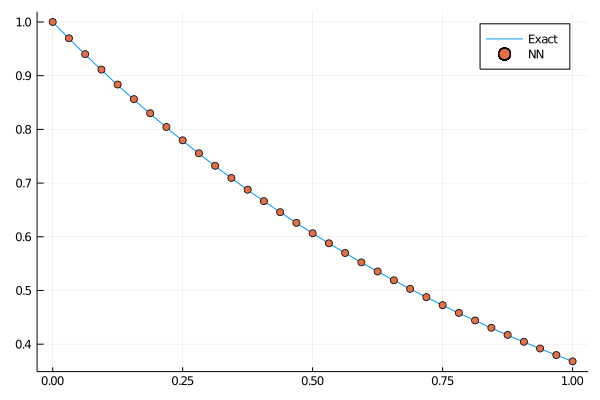

In [174]:
using Plots
plot(xTest', yTest', label="Exact")
scatter!(xTest', yPred', label="NN")

In [113]:
using Flux, DiffEqFlux, Optim, Kinetic, FiniteDifferences

In [204]:
xspan = 0.f0:0.1f0:2.f0
yspan = 0.f0:0.1f0:1.f0

x = collect(xspan)
y = collect(yspan)
nx = length(x)
ny = length(y)
xMesh, yMesh = meshgrid(x, y)
xMesh1D = reshape(xMesh, (1, :))
yMesh1D = reshape(yMesh, (1, :))
mesh = cat(xMesh1D, yMesh1D; dims=1)

X = deepcopy(mesh)
Y = zeros(Float32, 1, length(x)*length(y))

1×231 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [218]:
xMesh

11×21 Array{Float32,2}:
 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  …  1.4  1.5  1.6  1.7  1.8  1.9  2.0
 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7     1.4  1.5  1.6  1.7  1.8  1.9  2.0
 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7     1.4  1.5  1.6  1.7  1.8  1.9  2.0
 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7     1.4  1.5  1.6  1.7  1.8  1.9  2.0
 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7     1.4  1.5  1.6  1.7  1.8  1.9  2.0
 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  …  1.4  1.5  1.6  1.7  1.8  1.9  2.0
 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7     1.4  1.5  1.6  1.7  1.8  1.9  2.0
 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7     1.4  1.5  1.6  1.7  1.8  1.9  2.0
 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7     1.4  1.5  1.6  1.7  1.8  1.9  2.0
 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7     1.4  1.5  1.6  1.7  1.8  1.9  2.0
 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  …  1.4  1.5  1.6  1.7  1.8  1.9  2.0

In [205]:
m = FastChain(FastDense(2, 20, tanh), FastDense(20, 20, tanh), FastDense(20, 1))
p = initial_params(m);
θ = [vcat(X...); p];
n = length(Y)

231

In [206]:
u(x) = sin.(π .* mat_x(x) ./ 2.f0) .* mat_y(x) .+ 
        mat_x(x) .* (2.f0 .- mat_x(x)) .* mat_y(x) .* (1.f0 .- mat_y(x)) .* m(x, p)
    
ux(x) = pullback(u, x)[2](ones(Int32,size(x)))[1] |> mat_x
uy(x) = pullback(u, x)[2](ones(Int32,size(x)))[1] |> mat_y

uxx(x) = pullback(ux, x)[2](ones(Int32,size(x)))[1] |> mat_x
uyy(x) = pullback(uy, x)[2](ones(Int32,size(x)))[1] |> mat_y

uyy (generic function with 1 method)

In [222]:
loss(θ)

loss = 185.38242f0


(185.38242f0, Float32[0.0 -0.09358635 … -0.07518044 -0.19258952])

In [221]:
function loss(θ)
    u0 =reshape(θ[1:n*2],2,n)
    p = θ[2n+1:end]
    
    u(x) = sin.(π .* mat_x(x) ./ 2.f0) .* mat_y(x) .+ 
        mat_x(x) .* (2.f0 .- mat_x(x)) .* mat_y(x) .* (1.f0 .- mat_y(x)) .* m(x, p)
    
    #ux(x) = pullback(u, x)[2](ones(size(x)))[1] |> mat_x
    #uy(x) = pullback(u, x)[2](ones(size(x)))[1] |> mat_y
    
    #uxx(x) = pullback(ux, x)[2](ones(size(x)))[1] |> mat_x
    #uyy(x) = pullback(uy, x)[2](ones(size(x)))[1] |> mat_y
    
    function ux(x)
        uu = reshape(u(x), (ny, :))
        xx = reshape(X[1,:], (ny, :))
        dux = zeros(eltype(x), ny, nx)
        for i in 1:ny
            dux[i,:] .= diff(uu[i,:], xx[i,:])
        end
        
        return reshape(dux, (1, :))
    end
    function uy(x)
        uu = reshape(u(x), (ny, :))
        yy = reshape(X[2,:], (ny, :))
        duy = zeros(eltype(x), ny, nx)
        for j in 1:nx
            duy[:,j] .= diff(uu[:,j], yy[:,j])
        end
        
        return reshape(duy, (1, :))
    end
    
    function uxx(x)
        uu = reshape(ux(x), (ny, :))
        xx = reshape(X[1,:], (ny, :))
        d2ux = zeros(eltype(x), ny, nx)
        for i in 1:ny
            d2ux[i,:] .= diff(uu[i,:], xx[i,:])
        end
        
        return reshape(d2ux, (1, :))
    end
    function uyy(x)
        uu = reshape(uy(x), (ny, :))
        yy = reshape(X[2,:], (ny, :))
        d2uy = zeros(eltype(x), ny, nx)
        for j in 1:nx
            d2uy[:,j] .= diff(uu[:,j], yy[:,j])
        end
        
        return reshape(d2uy, (1, :))
    end
    
    #ux(x) = diff(u(x)[:],x[1,:]) |> permutedims
    #uy(x) = diff(u(x)[:],x[2,:]) |> permutedims
    
    #uxx(x) = diff(ux(x)[:],x[1,:]) |> permutedims
    #uyy(x) = diff(uy(x)[:],x[2,:]) |> permutedims 
    
    pred = uxx(u0) .+ uyy(u0)
    loss = sum(abs2, pred)
    
    @show loss
    
    return loss, pred
end

loss (generic function with 1 method)

In [223]:
res = DiffEqFlux.sciml_train(loss, θ, LBFGS(); cb=cb, maxiters=200, diffmode=DiffEqFlux.ReverseDiffMode())

TrackedReal<GMm>(185.38246, 0.0, HwQ, ---)

loss = TrackedReal<GMm>(185.38246, 0.0, HwQ, ---)
loss = TrackedReal<C4G>(2.364455e31, 0.0, 4WS, ---)
loss = TrackedReal<5Jb>(185.38246, 0.0, FgN, ---)
loss = TrackedReal<Ks4>(2.1572193e28, 0.0, 8p1, ---)
loss = TrackedReal<4D9>(185.38246, 0.0, KSG, ---)
loss = TrackedReal<Ho4>(1.8255658e25, 0.0, 6uM, ---)
loss = TrackedReal<2ck>(185.38246, 0.0, 7qn, ---)
loss = TrackedReal<Ha1>(1.2989721e22, 0.0, 4xN, ---)
loss = TrackedReal<4Cr>(185.38246, 0.0, Lar, ---)
loss = TrackedReal<3Ie>(5.6251174e18, 0.0, BoA, ---)
loss = TrackedReal<Aql>(185.38246, 0.0, 8xU, ---)
loss = TrackedReal<HQs>(4.1587162e15, 0.0, FzR, ---)
loss = TrackedReal<1gF>(185.38246, 0.0, 21P, ---)
loss = TrackedReal<EMS>(1.109353e14, 0.0, IcR, ---)
loss = TrackedReal<JyV>(185.38246, 0.0, IAQ, ---)
loss = 

TrackedReal<2f0>(84.93698, 0.0, KHo, ---)

TrackedReal<6Mi>(1.5544261e11, 0.0, Kru, ---)
loss = TrackedReal<6mi>(185.37158, 0.0, Lhg, ---)
loss = TrackedReal<2f0>(84.93698, 0.0, KHo, ---)
loss = TrackedReal<F2O>(71.71294, 0.0, GSS, ---)
loss = 

TrackedReal<Ho3>(70.51635, 0.0, 2bV, ---)

TrackedReal<519>(165.82265, 0.0, Lek, ---)
loss = TrackedReal<Ho3>(70.51635, 0.0, 2bV, ---)
loss = TrackedReal<87Y>(57.301502, 0.0, 4P2, ---)
loss = TrackedReal<IJs>(73.99749, 0.0, KeI, ---)
loss = 

TrackedReal<7tl>(50.460377, 0.0, 2xU, ---)

TrackedReal<IuM>(33.99385, 0.0, 85B, ---)

TrackedReal<7tl>(50.460377, 0.0, 2xU, ---)
loss = TrackedReal<AD9>(37.504257, 0.0, Lom, ---)
loss = TrackedReal<J6j>(82.53739, 0.0, AfD, ---)
loss = TrackedReal<IuM>(33.99385, 0.0, 85B, ---)
loss = 

TrackedReal<Gon>(29.328562, 0.0, LFw, ---)

TrackedReal<6IK>(29.330164, 0.0, 4wJ, ---)
loss = TrackedReal<Gon>(29.328562, 0.0, LFw, ---)
loss = TrackedReal<Kwx>(25.27212, 0.0, GXJ, ---)


TrackedReal<BmA>(18.763626, 0.0, 3BS, ---)

TrackedReal<KTA>(13.274743, 0.0, HpA, ---)

loss = TrackedReal<1Bn>(18.82556, 0.0, Ad3, ---)
loss = TrackedReal<BmA>(18.763626, 0.0, 3BS, ---)
loss = TrackedReal<40x>(13.316126, 0.0, 2bJ, ---)
loss = TrackedReal<KTA>(13.274743, 0.0, HpA, ---)


TrackedReal<EpU>(11.601741, 0.0, Bay, ---)

loss = TrackedReal<Fqf>(11.923809, 0.0, 4Kq, ---)
loss = TrackedReal<H1t>(17.062895, 0.0, 7vd, ---)
loss = TrackedReal<EpU>(11.601741, 0.0, Bay, ---)
loss = TrackedReal<Gyl>(10.227618, 0.0, AJX, ---)


TrackedReal<9en>(9.546558, 0.0, 8xC, ---)

loss = TrackedReal<CAj>(12.132928, 0.0, C8t, ---)
loss = TrackedReal<9en>(9.546558, 0.0, 8xC, ---)
loss = TrackedReal<LSu>(8.330797, 0.0, 7iy, ---)
loss = 

TrackedReal<Hnd>(8.095341, 0.0, HBo, ---)

TrackedReal<92o>(6.4194503, 0.0, 7Lu, ---)

TrackedReal<JeQ>(13.827785, 0.0, 8GG, ---)
loss = TrackedReal<Hnd>(8.095341, 0.0, HBo, ---)
loss = TrackedReal<JXy>(7.1311417, 0.0, 3cg, ---)
loss = TrackedReal<Ijr>(7.344512, 0.0, Lwx, ---)
loss = TrackedReal<92o>(6.4194503, 0.0, 7Lu, ---)


TrackedReal<HmF>(5.0404806, 0.0, 3G6, ---)

loss = TrackedReal<FHM>(5.2324495, 0.0, 3Ep, ---)
loss = TrackedReal<8lt>(11.325604, 0.0, VKo, ---)
loss = TrackedReal<HmF>(5.0404806, 0.0, 3G6, ---)
loss = TrackedReal<PFb>(4.227311, 0.0, 5ak, ---)


TrackedReal<1IU>(3.9294286, 0.0, HLK, ---)

loss = TrackedReal<Ffd>(6.133299, 0.0, 2U4, ---)
loss = TrackedReal<1IU>(3.9294286, 0.0, HLK, ---)
loss = TrackedReal<1On>(3.0120947, 0.0, 2mp, ---)
loss = TrackedReal<Bui>(6.899593, 0.0, 2sK, ---)


TrackedReal<2Dg>(2.8198102, 0.0, Lsj, ---)

loss = TrackedReal<2Dg>(2.8198102, 0.0, Lsj, ---)
loss = TrackedReal<FCL>(2.2305021, 0.0, JDI, ---)
loss = TrackedReal<4tM>(6.0502853, 0.0, GXJ, ---)
loss = 

TrackedReal<7Nw>(2.166994, 0.0, Ad3, ---)

TrackedReal<Gah>(1.6641568, 0.0, KKp, ---)

TrackedReal<7Nw>(2.166994, 0.0, Ad3, ---)
loss = TrackedReal<C8k>(1.7858166, 0.0, ACR, ---)
loss = TrackedReal<EUk>(2.850199, 0.0, 5b6, ---)
loss = TrackedReal<Gah>(1.6641568, 0.0, KKp, ---)
loss = 

TrackedReal<BA8>(1.3465462, 0.0, 5ak, ---)

TrackedReal<6XJ>(1.396851, 0.0, 9SO, ---)
loss = TrackedReal<D3l>(2.6233888, 0.0, IXS, ---)
loss = TrackedReal<BA8>(1.3465462, 0.0, 5ak, ---)
loss = TrackedReal<61I>(1.15404, 0.0, 8TU, ---)
loss = 

TrackedReal<I4T>(1.112029, 0.0, E72, ---)

TrackedReal<1AY>(1.9424593, 0.0, LVV, ---)
loss = TrackedReal<I4T>(1.112029, 0.0, E72, ---)
loss = TrackedReal<17d>(0.9431792, 0.0, HCv, ---)


TrackedReal<L5F>(0.9081669, 0.0, K9a, ---)

loss = TrackedReal<9vu>(1.6647938, 0.0, LFw, ---)
loss = TrackedReal<L5F>(0.9081669, 0.0, K9a, ---)
loss = TrackedReal<FnR>(0.82698697, 0.0, E04, ---)
loss = TrackedReal<IiU>(1.2545162, 0.0, 3BS, ---)


TrackedReal<B1H>(0.81438094, 0.0, 5l3, ---)

TrackedReal<GFL>(0.7362175, 0.0, Ke9, ---)

loss = TrackedReal<B1H>(0.81438094, 0.0, 5l3, ---)
loss = TrackedReal<Kmx>(0.75601256, 0.0, GWf, ---)
loss = TrackedReal<7FN>(0.9083885, 0.0, 724, ---)
loss = TrackedReal<GFL>(0.7362175, 0.0, Ke9, ---)


TrackedReal<LHX>(0.69045186, 0.0, AfD, ---)

loss = TrackedReal<L57>(0.69673043, 0.0, Bay, ---)
loss = TrackedReal<CVL>(0.9016555, 0.0, Lom, ---)
loss = TrackedReal<LHX>(0.69045186, 0.0, AfD, ---)
loss = TrackedReal<JAd>(0.65250677, 0.0, 8xC, ---)


TrackedReal<AFu>(0.64246714, 0.0, 8GG, ---)

loss = TrackedReal<5xb>(0.7832208, 0.0, 4wJ, ---)
loss = TrackedReal<AFu>(0.64246714, 0.0, 8GG, ---)
loss = TrackedReal<5x9>(0.6170332, 0.0, 7KQ, ---)
loss = 

TrackedReal<Lgs>(0.59955186, 0.0, Lwx, ---)

TrackedReal<3A4>(0.62763333, 0.0, 3fj, ---)
loss = TrackedReal<Lgs>(0.59955186, 0.0, Lwx, ---)
loss = TrackedReal<1c3>(0.5676365, 0.0, ErP, ---)
loss = TrackedReal<A84>(0.7926209, 0.0, 3Ep, ---)
loss = 

TrackedReal<8yi>(0.5647395, 0.0, 1Fy, ---)

TrackedReal<HXu>(0.53856283, 0.0, 97F, ---)

TrackedReal<8yi>(0.5647395, 0.0, 1Fy, ---)
loss = TrackedReal<5k6>(0.5429263, 0.0, DVR, ---)
loss = TrackedReal<G5X>(0.6388952, 0.0, IpE, ---)
loss = TrackedReal<HXu>(0.53856283, 0.0, 97F, ---)
loss = 

TrackedReal<BYB>(0.51136017, 0.0, 9uR, ---)

TrackedReal<JH6>(0.5201365, 0.0, E5C, ---)
loss = TrackedReal<48H>(0.54793996, 0.0, KmQ, ---)
loss = TrackedReal<BYB>(0.51136017, 0.0, 9uR, ---)
loss = TrackedReal<sSz>(0.4919587, 0.0, LxR, ---)
loss = 

TrackedReal<KPm>(0.48721918, 0.0, BTr, ---)

TrackedReal<GjE>(0.5641654, 0.0, LFw, ---)
loss = TrackedReal<KPm>(0.48721918, 0.0, BTr, ---)
loss = TrackedReal<FzH>(0.4726146, 0.0, Exj, ---)
loss = TrackedReal<30o>(0.515787, 0.0, 7lP, ---)
loss = 

TrackedReal<H25>(0.46813834, 0.0, I7S, ---)

TrackedReal<9PL>(0.4547429, 0.0, 3G6, ---)

TrackedReal<H25>(0.46813834, 0.0, I7S, ---)
loss = TrackedReal<EHF>(0.45613492, 0.0, 2kF, ---)
loss = TrackedReal<1uZ>(0.5312527, 0.0, VKo, ---)
loss = TrackedReal<9PL>(0.4547429, 0.0, 3G6, ---)
loss = 

TrackedReal<Y5h>(0.44299448, 0.0, 62P, ---)

TrackedReal<5lT>(0.44548756, 0.0, 5ak, ---)
loss = TrackedReal<HDZ>(0.47685844, 0.0, 43Y, ---)
loss = TrackedReal<Y5h>(0.44299448, 0.0, 62P, ---)
loss = TrackedReal<9lI>(0.43492824, 0.0, E72, ---)
loss = 

TrackedReal<CVP>(0.43260074, 0.0, 8GG, ---)

TrackedReal<9Xt>(0.46034187, 0.0, 8zU, ---)
loss = TrackedReal<CVP>(0.43260074, 0.0, 8GG, ---)
loss = TrackedReal<7U2>(0.427974, 0.0, 7KQ, ---)


TrackedReal<7oT>(0.4260706, 0.0, 7lP, ---)

loss = TrackedReal<Fa6>(0.43711263, 0.0, 3fj, ---)
loss = TrackedReal<7oT>(0.4260706, 0.0, 7lP, ---)
loss = TrackedReal<Gxb>(0.42091018, 0.0, 5b6, ---)
loss = TrackedReal<LWl>(0.44438267, 0.0, KKp, ---)


TrackedReal<DWN>(0.41992018, 0.0, CFH, ---)

TrackedReal<7hW>(0.41578278, 0.0, DsM, ---)

loss = TrackedReal<DWN>(0.41992018, 0.0, CFH, ---)
loss = TrackedReal<ALj>(0.41611627, 0.0, BBb, ---)
loss = TrackedReal<AxV>(0.44331983, 0.0, GMx, ---)
loss = TrackedReal<7hW>(0.41578278, 0.0, DsM, ---)


TrackedReal<4lz>(0.41289112, 0.0, B7R, ---)

loss = TrackedReal<1Vs>(0.4137551, 0.0, HQI, ---)
loss = TrackedReal<3Lp>(0.41753948, 0.0, 7yQ, ---)
loss = TrackedReal<4lz>(0.41289112, 0.0, B7R, ---)
loss = 

TrackedReal<8Cl>(0.41044402, 0.0, ATF, ---)

TrackedReal<F7h>(0.41090754, 0.0, GSw, ---)
loss = TrackedReal<JeQ>(0.41859552, 0.0, 3w7, ---)
loss = TrackedReal<8Cl>(0.41044402, 0.0, ATF, ---)
loss = TrackedReal<J1O>(0.4087353, 0.0, JuG, ---)
loss = 

TrackedReal<AIP>(0.40812147, 0.0, GQb, ---)

TrackedReal<3E1>(0.412884, 0.0, 9ey, ---)
loss = TrackedReal<AIP>(0.40812147, 0.0, GQb, ---)
loss = TrackedReal<Csx>(0.4066507, 0.0, 5Tp, ---)
loss = TrackedReal<J2Z>(0.41462025, 0.0, 9gp, ---)
loss = 

TrackedReal<3Tz>(0.4064311, 0.0, 1f7, ---)

TrackedReal<Cwj>(0.4047757, 0.0, vdq, ---)

TrackedReal<3Tz>(0.4064311, 0.0, 1f7, ---)
loss = TrackedReal<FG3>(0.40516433, 0.0, AUU, ---)
loss = TrackedReal<GHY>(0.4089052, 0.0, 1oP, ---)
loss = TrackedReal<Cwj>(0.4047757, 0.0, vdq, ---)
loss = 

TrackedReal<2Rw>(0.40334263, 0.0, LFw, ---)

TrackedReal<FWa>(0.4037671, 0.0, 9RC, ---)
loss = TrackedReal<J8J>(0.40568078, 0.0, Flf, ---)
loss = TrackedReal<2Rw>(0.40334263, 0.0, LFw, ---)


TrackedReal<AEJ>(0.40181184, 0.0, 3BS, ---)

loss = TrackedReal<Gve>(0.40223715, 0.0, GXJ, ---)
loss = TrackedReal<BY4>(0.40466276, 0.0, E04, ---)
loss = TrackedReal<AEJ>(0.40181184, 0.0, 3BS, ---)
loss = TrackedReal<IxP>(0.40070692, 0.0, 2bJ, ---)


TrackedReal<3TI>(0.40025267, 0.0, 724, ---)

loss = TrackedReal<Fzn>(0.40288916, 0.0, HpA, ---)
loss = TrackedReal<3TI>(0.40025267, 0.0, 724, ---)
loss = TrackedReal<A0u>(0.3989455, 0.0, 7vd, ---)
loss = TrackedReal<1pW>(0.40403068, 0.0, Bay, ---)


TrackedReal<7EB>(0.3986422, 0.0, 8UJ, ---)

TrackedReal<5Lg>(0.39721024, 0.0, 4wJ, ---)

loss = TrackedReal<7EB>(0.3986422, 0.0, 8UJ, ---)
loss = TrackedReal<55m>(0.39745483, 0.0, COw, ---)
loss = TrackedReal<9XS>(0.4025399, 0.0, 8xC, ---)
loss = TrackedReal<5Lg>(0.39721024, 0.0, 4wJ, ---)


TrackedReal<t0h>(0.3950081, 0.0, Exj, ---)

loss = TrackedReal<HqD>(0.39606357, 0.0, 1OR, ---)
loss = TrackedReal<FmA>(0.39564636, 0.0, 81d, ---)
loss = TrackedReal<t0h>(0.3950081, 0.0, Exj, ---)
loss = TrackedReal<ANy>(0.3936889, 0.0, ACR, ---)


TrackedReal<GCK>(0.39367276, 0.0, 1pi, ---)

loss = TrackedReal<3Hz>(0.4096931, 0.0, 5b6, ---)
loss = TrackedReal<GCK>(0.39367276, 0.0, 1pi, ---)
loss = TrackedReal<kYA>(0.3927704, 0.0, 1LG, ---)
loss = TrackedReal<BX7>(0.39334375, 0.0, BBb, ---)


TrackedReal<EGG>(0.3921943, 0.0, GMx, ---)

TrackedReal<GIY>(0.39057767, 0.0, 7yQ, ---)

loss = TrackedReal<EGG>(0.3921943, 0.0, GMx, ---)
loss = TrackedReal<Lip>(0.3909536, 0.0, 1WM, ---)
loss = TrackedReal<H0Z>(0.3946606, 0.0, 3jB, ---)
loss = TrackedReal<GIY>(0.39057767, 0.0, 7yQ, ---)


TrackedReal<8sN>(0.38906077, 0.0, Kru, ---)

loss = TrackedReal<Gcf>(0.38956147, 0.0, FBr, ---)
loss = TrackedReal<2Ee>(0.39098513, 0.0, J18, ---)
loss = TrackedReal<8sN>(0.38906077, 0.0, Kru, ---)
loss = 

TrackedReal<3pt>(0.3874057, 0.0, GSS, ---)

TrackedReal<DQL>(0.38787216, 0.0, LkL, ---)
loss = TrackedReal<33f>(0.39039546, 0.0, KXO, ---)
loss = TrackedReal<3pt>(0.3874057, 0.0, GSS, ---)
loss = TrackedReal<3qm>(0.38625842, 0.0, 2a3, ---)
loss = 

TrackedReal<6FV>(0.3861818, 0.0, 4P2, ---)

TrackedReal<5C1>(0.39544636, 0.0, J0H, ---)
loss = TrackedReal<6FV>(0.3861818, 0.0, 4P2, ---)
loss = TrackedReal<NY4>(0.385223, 0.0, 9DG, ---)
loss = TrackedReal<3Mu>(0.38651374, 0.0, JVb, ---)
loss = 

TrackedReal<7lF>(0.38474095, 0.0, k6n, ---)

TrackedReal<6ae>(0.38339767, 0.0, 4wJ, ---)

TrackedReal<7lF>(0.38474095, 0.0, k6n, ---)
loss = TrackedReal<1z1>(0.38379842, 0.0, COw, ---)
loss = TrackedReal<17F>(0.38555813, 0.0, 8xC, ---)
loss = TrackedReal<6ae>(0.38339767, 0.0, 4wJ, ---)
loss = 

TrackedReal<1jX>(0.3820258, 0.0, Exj, ---)

TrackedReal<BEF>(0.3823126, 0.0, JDI, ---)
loss = TrackedReal<GRr>(0.3860516, 0.0, 81d, ---)
loss = TrackedReal<1jX>(0.3820258, 0.0, Exj, ---)
loss = TrackedReal<8zS>(0.3812735, 0.0, ACR, ---)
loss = 

TrackedReal<2Hz>(0.38116106, 0.0, 2kF, ---)

TrackedReal<2n1>(0.38536763, 0.0, 5b6, ---)
loss = TrackedReal<2Hz>(0.38116106, 0.0, 2kF, ---)
loss = TrackedReal<J6x>(0.3804593, 0.0, XH0, ---)
loss = TrackedReal<K0J>(0.3822215, 0.0, IXS, ---)
loss = 

TrackedReal<CK5>(0.3802135, 0.0, 5ak, ---)

TrackedReal<HPp>(0.3792344, 0.0, E72, ---)

TrackedReal<CK5>(0.3802135, 0.0, 5ak, ---)
loss = TrackedReal<Ezj>(0.37954202, 0.0, 9L1, ---)
loss = TrackedReal<1wU>(0.38062817, 0.0, iGE, ---)
loss = TrackedReal<HPp>(0.3792344, 0.0, E72, ---)
loss = 

TrackedReal<GqL>(0.37798584, 0.0, K8Z, ---)

TrackedReal<1CY>(0.37842026, 0.0, 5bB, ---)
loss = TrackedReal<8nW>(0.37936455, 0.0, 8GG, ---)
loss = TrackedReal<GqL>(0.37798584, 0.0, K8Z, ---)


TrackedReal<ELQ>(0.37687328, 0.0, I7S, ---)

loss = TrackedReal<B2b>(0.37706003, 0.0, 3fj, ---)
loss = TrackedReal<Ez4>(0.3811205, 0.0, 7lP, ---)
loss = TrackedReal<ELQ>(0.37687328, 0.0, I7S, ---)
loss = TrackedReal<5I6>(0.37608385, 0.0, KKp, ---)


TrackedReal<BkK>(0.37581638, 0.0, 6UN, ---)

loss = TrackedReal<K1Y>(0.37815848, 0.0, CFH, ---)
loss = TrackedReal<BkK>(0.37581638, 0.0, 6UN, ---)
loss = TrackedReal<4d4>(0.37491408, 0.0, GMx, ---)
loss = TrackedReal<KdP>(0.37801802, 0.0, DsM, ---)


TrackedReal<81R>(0.37467515, 0.0, HXH, ---)

TrackedReal<1bz>(0.37364104, 0.0, 8AH, ---)

loss = TrackedReal<81R>(0.37467515, 0.0, HXH, ---)
loss = TrackedReal<JJl>(0.37389, 0.0, 7yQ, ---)
loss = TrackedReal<6zx>(0.37611616, 0.0, 583, ---)
loss = TrackedReal<1bz>(0.37364104, 0.0, 8AH, ---)


 * Status: failure

 * Candidate solution
    Final objective value:     3.736410e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.34e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.16e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.03e-03 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.77e-03 ≰ 0.0e+00
    |g(x)|                 = 1.97e+00 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    63
    f(x) calls:    202
    ∇f(x) calls:   202


In [225]:
nxTest = 23; nyTest = 11

# meshgrid
xVecTest = Vector(range(x0, stop=x1, length=nxTest))
xMeshTest = repeat(reshape(xVecTest, 1, :), nyTest, 1)

yVecTest = Vector(range(y0, stop=y1, length=nyTest))
yMeshTest = repeat(yVecTest, 1, nxTest)

xMeshTest1D = reshape(xMeshTest, (1, :))
yMeshTest1D = reshape(yMeshTest, (1, :))
meshTest = cat(xMeshTest1D, yMeshTest1D; dims=1)

f_pred = u(meshTest)
f_pred = reshape(f_pred, (nyTest, nxTest))

11×23 Array{Float32,2}:
 0.0  0.0        0.0        0.0        …  0.0         0.0         -0.0
 0.0  0.0139855  0.0264323  0.0372633     0.00873017  0.00367869  -8.74228f-9
 0.0  0.0287703  0.0546602  0.0774648     0.0225938   0.0101104   -1.74846f-8
 0.0  0.0440564  0.0841176  0.119803      0.041265    0.0191323   -2.62268f-8
 0.0  0.0595477  0.114244   0.163487      0.0644282   0.0305863   -3.49691f-8
 0.0  0.0749584  0.1445     0.207758   …  0.0917794   0.04432     -4.37114f-8
 0.0  0.0900202  0.17438    0.251904      0.123029    0.0601871   -5.24537f-8
 0.0  0.104489   0.203424   0.295278      0.1579      0.0780484   -6.11959f-8
 0.0  0.118147   0.231223   0.337306      0.196135    0.0977718   -6.99382f-8
 0.0  0.130808   0.257424   0.377492      0.237488    0.119233    -7.86805f-8
 0.0  0.142315   0.281733   0.415415   …  0.281732    0.142315    -8.74228f-8

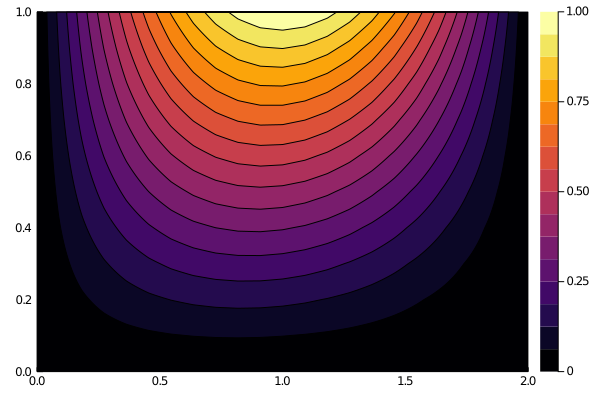

In [226]:
contourf(xVecTest, yVecTest, f_pred)